# Train a model

In this tutorial we will use TensorFlow to train a model.

In [1]:
import sys
import platform
import os

print("Python version: {}".format(sys.version))
print("{}".format(platform.platform()))

Python version: 3.7.10 (default, Feb 26 2021, 18:47:35) 
[GCC 7.3.0]
Linux-5.11.0-051100rc5-generic-x86_64-with-debian-buster-sid


# Biomedical Image Segmentation with U-Net

In this code example, we apply the U-Net architecture to segment brain tumors from raw MRI scans as shown below. With relatively little data we are able to train a U-Net model to accurately predict where tumors exist. 

The Dice coefficient (the standard metric for the BraTS dataset used in the study) for our model is about 0.82-0.88.  Menze et al. [reported](http://ieeexplore.ieee.org/document/6975210/) that expert neuroradiologists manually segmented these tumors with a cross-rater Dice score of 0.75-0.85, meaning that the model’s predictions are on par with what expert physicians have made.

<img src="images/figure1.png">

Since its introduction two years ago, the [U-Net](https://arxiv.org/pdf/1505.04597.pdf0) architecture has been used to create deep learning models for segmenting [nerves](https://github.com/jocicmarko/ultrasound-nerve-segmentation) in ultrasound images, [lungs](https://www.kaggle.com/c/data-science-bowl-2017#tutorial) in CT scans, and even [interference](https://github.com/jakeret/tf_unet) in radio telescopes.

## What is U-Net?
U-Net is designed like an [auto-encoder](https://en.wikipedia.org/wiki/Autoencoder). It has an encoding path (“contracting”) paired with a decoding path (“expanding”) which gives it the “U” shape.  However, in contrast to the autoencoder, U-Net predicts a pixelwise segmentation map of the input image rather than classifying the input image as a whole. For each pixel in the original image, it asks the question: “To which class does this pixel belong?” This flexibility allows U-Net to predict different parts of the tumor simultaneously.

<img src="images/unet.png">

This module loads the data generator from `dataloader.py`, creates a TensorFlow/Keras model from `model.py`, trains the model on the data, and then saves the best model.

### TensorFlow Version Check

Check to see what version of TensorFlow is installed and if it has [Intel DNNL optimizations](https://software.intel.com/content/www/us/en/develop/articles/intel-optimization-for-tensorflow-installation-guide.html)

In [2]:
def test_intel_tensorflow():
    """
    Check if Intel version of TensorFlow is installed
    """
    import tensorflow as tf
    
    print("We are using Tensorflow version {}".format(tf.__version__))
           
    major_version = int(tf.__version__.split(".")[0])
    if major_version >= 2:
       from tensorflow.python import _pywrap_util_port
       print("Intel-optimizations (DNNL) enabled:", _pywrap_util_port.IsMklEnabled())
    else:
       print("Intel-optimizations (DNNL) enabled:", tf.pywrap_tensorflow.IsMklEnabled()) 

test_intel_tensorflow()

We are using Tensorflow version 2.4.1
Intel-optimizations (DNNL) enabled: True


## Training Time!

The bulk of the training section can be broken down in 4 simple steps:
1. Load the training data
1. Define the model
3. Train the model on the data
4. Evaluate the best model
    

#### Step 1 : Loading the BraTS data set from the tf.data loader

In [3]:
data_path = "/data/medical_decathlon/Task01_BrainTumour/"

crop_dim=128  # Original resolution (240)
batch_size = 128
seed=816
train_test_split=0.85

In [4]:
from dataloader import DatasetGenerator, get_decathlon_filelist

trainFiles, validateFiles, testFiles = get_decathlon_filelist(data_path=data_path, seed=seed, split=train_test_split)

ds_train = DatasetGenerator(trainFiles, 
                            batch_size=batch_size, 
                            crop_dim=[crop_dim, crop_dim], 
                            augment=True, seed=seed)

ds_validation = DatasetGenerator(validateFiles, 
                                 batch_size=batch_size, 
                                 crop_dim=[crop_dim, crop_dim], 
                                 augment=False, 
                                 seed=seed)
    
ds_test = DatasetGenerator(testFiles, 
                           batch_size=batch_size, 
                           crop_dim=[crop_dim, crop_dim], 
                           augment=False, 
                           seed=seed)


******************************
Dataset name:         BRATS
Dataset description:  Gliomas segmentation tumour and oedema in on brain images
Tensor image size:    4D
Dataset release:      2.0 04/05/2018
Dataset reference:    https://www.med.upenn.edu/sbia/brats2017.html
Dataset license:      CC-BY-SA 4.0
******************************
Number of training files   = 411
Number of validation files = 36
Number of testing files    = 37


## Plot some samples of the dataset

We can use the DatasetGenerator's plot_samples function to plot a few samples of the dataset. Note that with `augment` set to True, we have randomly cropped, flipped, and rotated the images.

(128, 128, 128, 1)


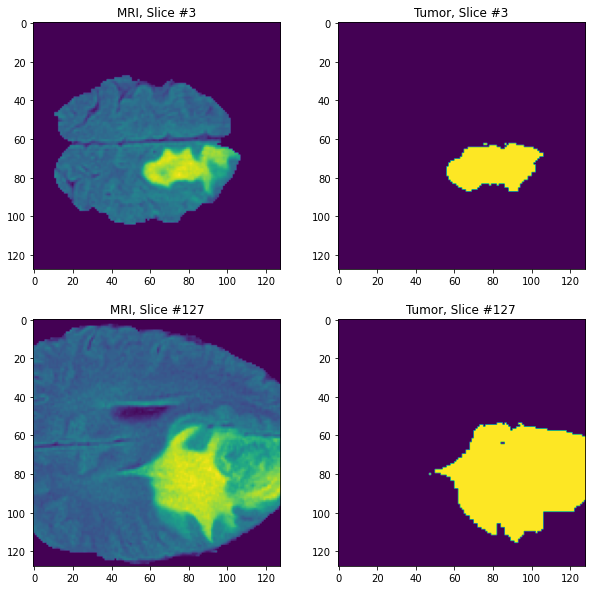

In [5]:
ds_train.plot_samples()

(128, 128, 128, 1)


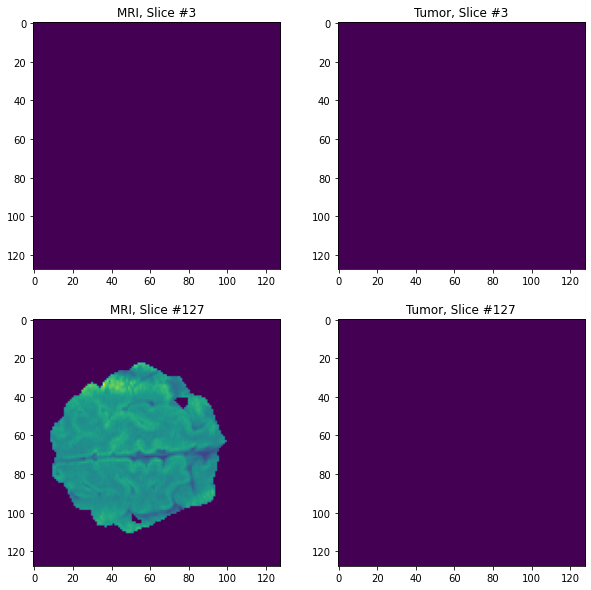

In [6]:
ds_validation.plot_samples()

#### Step 2: Define the model

In [7]:
from model import unet

print("-" * 30)
print("Creating and compiling model ...")
print("-" * 30)

unet_model = unet(fms=8, learning_rate=1e-4, use_dropout=False, use_upsampling=False)

model = unet_model.create_model(
        ds_train.get_input_shape(), 
        ds_train.get_output_shape())

model_filename, model_callbacks = unet_model.get_callbacks()

# # If there is a current saved file, then load weights and start from there.
# saved_model = os.path.join(args.output_path, args.inference_filename)
# if os.path.isfile(saved_model):
#     model.load_weights(saved_model)

------------------------------
Creating and compiling model ...
------------------------------
Data format = channels_last
Using Transposed Convolution
Model: "2DUNet_Brats_Decathlon"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
MRImages (InputLayer)           [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
encodeAa (Conv2D)               (None, 128, 128, 8)  80          MRImages[0][0]                   
__________________________________________________________________________________________________
encodeAb (Conv2D)               (None, 128, 128, 8)  584         encodeAa[0][0]                   
__________________________________________________________________________________________________
poolA (MaxPooling2D)    

The code snippet below draws the model using Keras' built-in `plot_model`. Compare with the implementation of `model.py`

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


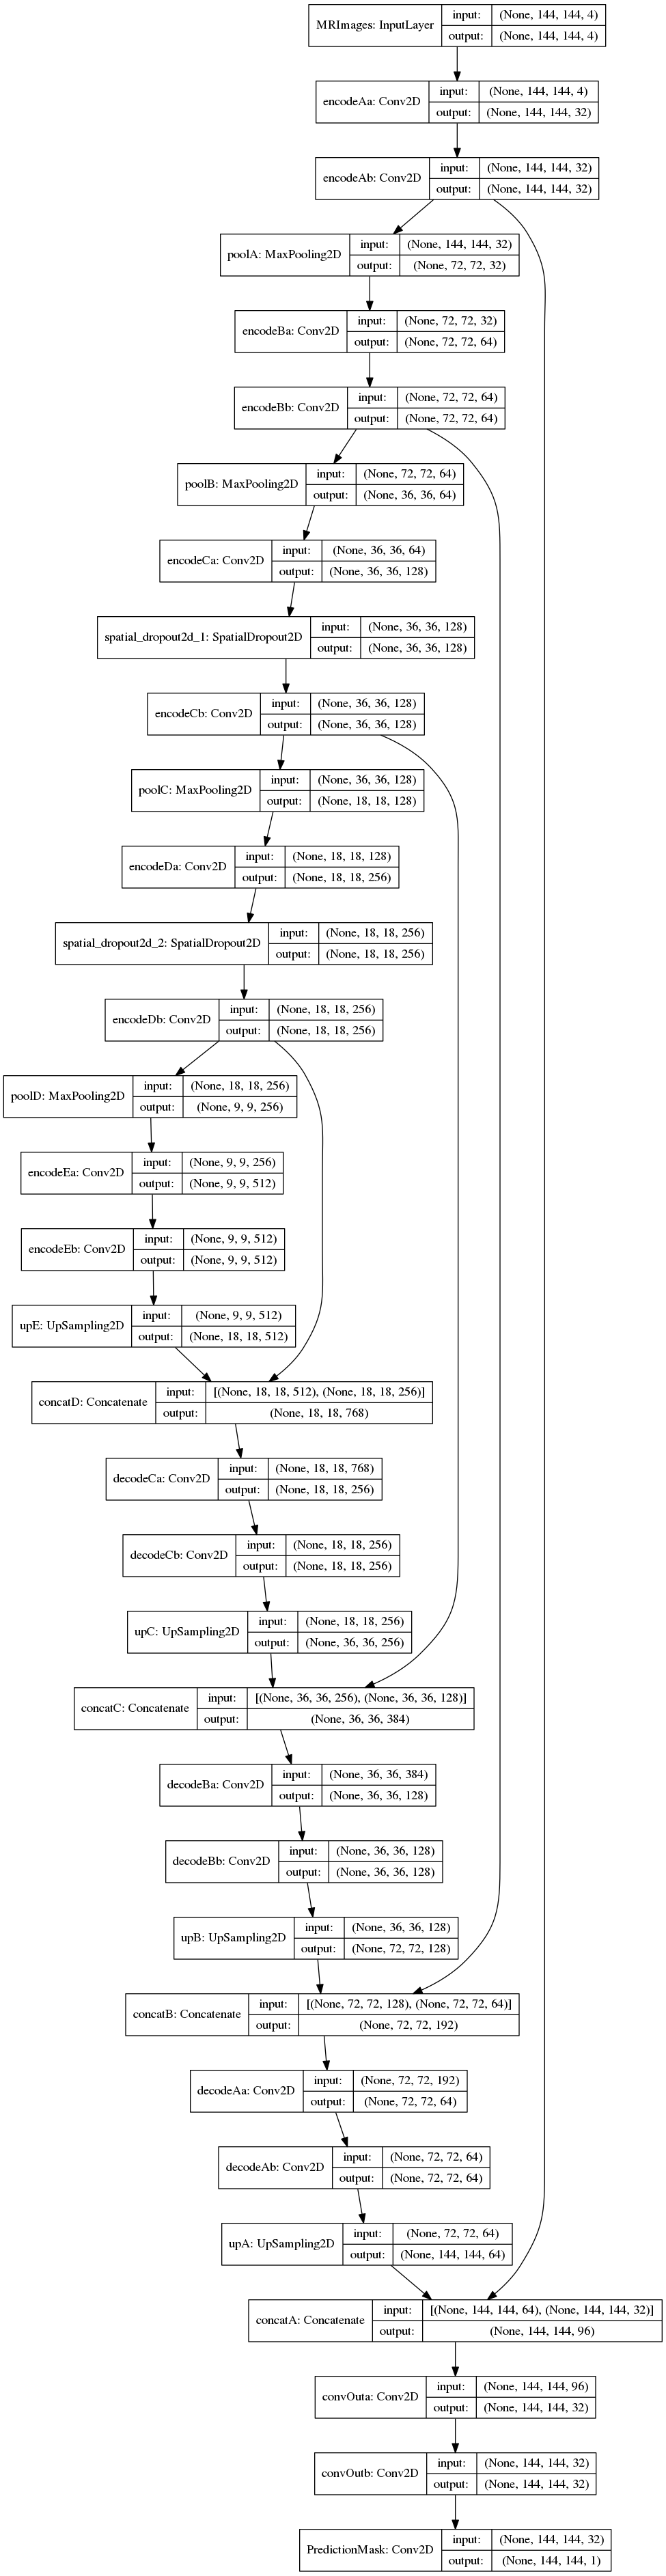

In [8]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

plot_model(model,
           to_file='images/model.png',
           show_shapes=True,
           show_layer_names=True,
           rankdir='TB'
            )
Image('images/model.png')

#### Step 3: Train the model on the data

In [9]:
import datetime

start_time = datetime.datetime.now()
print("Training started at {}".format(start_time))

n_epoch = 2  # Train for this many epochs

history = model.fit(ds_train,
              epochs=n_epoch,
              validation_data=ds_validation,
              verbose=1,
              callbacks=model_callbacks)

print("Total time elapsed for training = {} seconds".format(datetime.datetime.now() - start_time))
print("Training finished at {}".format(datetime.datetime.now()))
    
# Append training log
# with open("training.log","a+") as fp:
#     fp.write("{}: {}\n".format(datetime.datetime.now(),
#                              history.history["val_dice_coef"]))

Training started at 2021-04-03 20:32:11.127772
Epoch 1/2
 21/497 [>.............................] - ETA: 24:07 - loss: 2.5452 - dice_coef: 0.0650 - soft_dice_coef: 0.0678

KeyboardInterrupt: 

#### Step 4: Evaluate the best model

In [ ]:
print("-" * 30)
print("Loading the best trained model ...")
print("-" * 30)
unet_model.evaluate_model(model_filename, ds_testing)

## End: In this tutorial, you have learnt:
* What is the U-Net model
* Comparing training times - Tensorflow DNNL vs Tensorflow (stock)
* How to tweak a series of environment variables to get better performance out of DNNL
* How to tweak a series of Tensorflow-related and neural-network specific parameters for better performance

*Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License. SPDX-License-Identifier: EPL-2.0*

*Copyright (c) 2019-2020 Intel Corporation*